#**A Convolutional Neural Network for predicting HIV Integration Sites**
###This python notebook is the result of degree project done by Senad Matuh Delic, the full-text describing the work in full can be found here (link to be added).

###Download the dataset for HIV Integration Sites
#####This can be done fetching the pre-generated dataset from AWS using the code below. Otherwise you can generate your own dataset using our dataset generator tool [Retrovirus Integration Database Parser & Training Set Generator](https://github.com/senadmd/RetrovirusIntegrationDatabaseParser).

In [1]:
!wget -O data.zip "https://kth-project.s3.eu-north-1.amazonaws.com/data.zip"

--2020-02-16 13:46:12--  https://kth-project.s3.eu-north-1.amazonaws.com/data.zip
Resolving kth-project.s3.eu-north-1.amazonaws.com (kth-project.s3.eu-north-1.amazonaws.com)... 52.95.171.0
Connecting to kth-project.s3.eu-north-1.amazonaws.com (kth-project.s3.eu-north-1.amazonaws.com)|52.95.171.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345929473 (330M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 329.90M  10.8MB/s    in 33s     

2020-02-16 13:46:47 (9.86 MB/s) - ‘data.zip’ saved [345929473/345929473]



###Extract the compressed files
####The files containing the "_validation" suffix are files part of the validation set and should only be used when validating the neural network.

In [2]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/DNAString.txt      
  inflating: data/DNAString_validation.txt  
  inflating: data/inserts.txt        
  inflating: data/inserts_validation.txt  
  inflating: data/labels.txt         
  inflating: data/labels_validation.txt  
  inflating: data/positions.txt      


###Parse the one-hot encoded DNA sampled at HIV insert positions  from the inserts.txt file (training data)
#####The DNA is encoded into four channels indicating occurrence of the nucleotides A,C,G,T. The one-hot encoded DNA string in the dataset  contains nucleotides 100 bp before integration site and 100 bp of nucleotides after the integration site fetched from the GRCh37/hg19 genome using the [UCSC Genome API](http://genome.ucsc.edu/goldenPath/help/api.html). The HIV Integration positions have been parsed from [Retrovirus Integration Database](https://rid.ncifcrf.gov) using our own tool described above, the positions parsed can be found in the extracted file *positions.txt*.

In [0]:
import pandas as pd
df=pd.read_csv('data/inserts.txt', sep=',',header=None)

####What inserts.txt file looks like
#####We see that the DNA string is a 800 length one-hot encoded string. This is result of four A-C-G-T channels of 200 bp being one-hot encoded and concatenated into a single string. Note that no proviral HIV DNA is contained in the files extracted, these contain only DNA sampled at the positions of HIV integration from the GRCh37/hg19 genome. Regarding false HIV integration DNA samples, these have randomly sampled from the GRCh37/hg19 genome with safeguards of collisions or overlap between the sets.

In [4]:
df.head

<bound method NDFrame.head of          0    1    2    3    4    5    6    ...  793  794  795  796  797  798  799
0          0    0    0    0    1    0    0  ...    0    0    0    0    0    1    1
1          0    1    0    0    0    0    1  ...    1    1    1    0    0    1    1
2          0    0    0    0    1    0    0  ...    0    0    0    0    1    0    0
3          0    1    0    0    0    0    1  ...    0    0    0    0    0    0    0
4          0    1    0    0    0    0    0  ...    1    1    1    1    0    1    0
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1595819    0    0    0    0    0    0    0  ...    1    0    0    0    0    0    1
1595820    1    1    1    1    0    0    1  ...    1    1    0    0    0    1    0
1595821    1    0    0    0    1    1    1  ...    0    0    1    0    1    0    0
1595822    0    0    1    0    0    1    0  ...    1    1    1    1    0    0    0
1595823    0    0    0    0    0    0    0  ...    0    0

###Parse the training labels

In [0]:
labelsdf=pd.read_csv('data/labels.txt', sep=',',header=None)

####Lets get an look into the label data
#####Below we see that each second label is a false label, this means that each second row in the insert.txt file is a false integration event randomly sampled from the GRCh37/hg19 genome

In [0]:
labelsdf.head

<bound method NDFrame.head of          0
0        1
1        0
2        1
3        0
4        1
...     ..
1595819  0
1595820  1
1595821  0
1595822  1
1595823  0

[1595824 rows x 1 columns]>

###Import Tensorflow and Numpy

In [6]:
import numpy as np
import tensorflow as tf
tf.enable_eager_execution() # define eager execution to be able to preview our training data

###Split the training set into smaller equal size batches for less RAM consumption
####Below we split our dataset using the divisor (272).

In [0]:
# Split traning data into equal parts
data_chunks = list(np.split(df.values, 272)) 
labels_chunks = list(np.split(labelsdf.values, 272))

####Lets confirm that we have 272 equal parts

In [8]:
len(data_chunks)


272

####Lets examine the size of each batch

In [9]:
data_chunks[0].shape

(5867, 800)

###Reshaping each row to keep dimensionality of the data contained in each row
####Before reshaping the data, lets look at how a single insert row look like

In [0]:
data_chunks[0][0]

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

####Lets structure our data so that we don´t lose the dimensionality information contained in the seperate one-hot encoded channels
#####Lets reshape each single row into four seperate channels corresponding to the nucleotides A-C-G-T.
#####We can test this with the code below.

In [0]:
# Below we repshape a single batch chunk for demonstration
chunk_reshaped = data_chunks[0].reshape([data_chunks[0].shape[0],4,200])

In [13]:
# Lets examine the shape and data contained in the first row of chunk_reshaped
chunk_reshaped[0]

array([[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 

###Define batch set generator function
####This batch set generator function will reshape each batch and tie together each tranining data row with each label row using the python [zip function](https://docs.python.org/3/library/functions.html#zip).
####The generator will reshape the data similarly as above, with one difference, to use our data as input for a [tensorflow CNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D?version=stable) we need to add a channel dimension to our data. Since the default input data format for a tensorflow CNN is (batch, height, width, channels) per *channels_last* setting, we need to add an extra last dimension channel.

In [0]:
# define a generator to reshape our dataset and zip each insert row with each label row
batchSize=data_chunks[0].shape[0]
def genenerator():
    for i, j in zip(data_chunks, labels_chunks):
        yield i.reshape([batchSize,4,200,-1]), j
#create a tensor for our training dataset
train_dataset = tf.data.Dataset.from_generator(genenerator,output_shapes=([batchSize,4,200,1],[batchSize,1]),output_types=(tf.float32, tf.float32)) 



####Lets verify that the output from the batch set generator is indeed the same as in the previous example (with the exception of the extra dimension)

In [15]:
# define an iterator over our training data and get first next entry
trainingData, trainingLabels = next(iter(train_dataset))
print('Our first training label is:',trainingLabels[0].numpy()[0])
print('Our first training row has the shape:',trainingData[0].numpy().shape)
print('Our previous example has the shape:',chunk_reshaped[0].shape)
print('Our first training row has the following entries in the first channel:',trainingData[0].numpy()[0][0],
      trainingData[0].numpy()[0][1],trainingData[0].numpy()[0][2],trainingData[0].numpy()[0][3],trainingData[0].numpy()[0][2],trainingData[0].numpy()[0][4],"..")
print('Our first training row has the following entries in the last channel:',trainingData[0].numpy()[3][0],
      trainingData[0].numpy()[3][1],trainingData[0].numpy()[3][2],trainingData[0].numpy()[3][3],trainingData[0].numpy()[3][2],trainingData[0].numpy()[3][4],"..")
print('Our previous example row has the following entries in the first channel:',chunk_reshaped[0][0][0],chunk_reshaped[0][0][1],chunk_reshaped[0][0][2],chunk_reshaped[0][0][3],chunk_reshaped[0][0][4], "..")
print('Our previous example row has the following entries in the last channel:',chunk_reshaped[0][3][0],chunk_reshaped[0][3][1],chunk_reshaped[0][3][2],chunk_reshaped[0][3][3],chunk_reshaped[0][3][4],"..")

Our first training label is: 1.0
Our first training row has the shape: (4, 200, 1)
Our previous example has the shape: (4, 200)
Our first training row has the following entries in the first channel: [0.] [0.] [0.] [0.] [0.] [1.] ..
Our first training row has the following entries in the last channel: [1.] [0.] [0.] [0.] [0.] [0.] ..
Our previous example row has the following entries in the first channel: 0 0 0 0 1 ..
Our previous example row has the following entries in the last channel: 1 0 0 0 0 ..


###Modeling the neural network with Keras
####Lets import Keras API and Matplotlib

In [0]:
#import keras API and matplotlib
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

####Define the layers for our CNN model

In [0]:
#create our neural network model
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(100, (4, 30), activation='relu', input_shape=(4, 200,1)))
model.add(layers.MaxPooling2D((3, 10),strides=1,padding='same'))
model.add(layers.Conv2D(50, (1, 10), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 1),strides=1))
model.add(layers.Conv2D(50, (1, 5), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation=tf.nn.sigmoid))

####Lets examine the layers and the number of parameters associated

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 171, 100)       12100     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 171, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 171, 50)        50050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 171, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 167, 50)        12550     
_________________________________________________________________
flatten (Flatten)            (None, 8350)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                4

####Compile our Keras CNN model

In [0]:
#compile our model
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

####Train the neural network in batches

In [20]:
#train our neural network
#use batch training
for trainData, trainLabels in iter(train_dataset):
 model.fit(trainData, trainLabels,batch_size=batchSize, epochs=5)


Train on 5867 samples
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5867/5867 [==============================] - 9s 2ms/sample - loss: 0.6926 - acc: 0.5216
Epoch 2/5
5867/5867 [==============================] - 0s 29us/sample - loss: 0.6926 - acc: 0.5229
Epoch 3/5
5867/5867 [==============================] - 0s 29us/sample - loss: 0.6925 - acc: 0.5238
Epoch 4/5
5867/5867 [==============================] - 0s 29us/sample - loss: 0.6925 - acc: 0.5253
Epoch 5/5
5867/5867 [==============================] - 0s 29us/sample - loss: 0.6925 - acc: 0.5258
Train on 5867 samples
Epoch 1/5
5867/5867 [==============================] - 0s 31us/sample - loss: 0.6929 - acc: 0.5040
Epoch 2/5
5867/5867 [==============================] - 0s 29us/sample - loss: 0.6929 - acc: 0.5050
Epoch 3/5
5867/5867 [==============================] - 0s 29us/sample - loss: 0.6929 - acc: 0.5057
Epoch 4/5
5867/5867 [==============================] - 0s 29us/sample -

###Validating the model
####To measure the performance and verify our model, lets import the validation set

In [0]:
#import validation data
labelsValidationDf=pd.read_csv('data/labels_validation.txt', sep=',',header=None)
dataValidationDf=pd.read_csv('data/inserts_validation.txt', sep=',',header=None)

####Lets inspect the size of our validation labels

In [22]:
#verify the length of validation set labels
len(labelsValidationDf)

177482

####Lets inspect the size of validation data and confirm that it is of same size as the validation set labels

In [0]:
#verify the length of validation set data
len(dataValidationDf)

177482

####Lets define a batch set generator for our validation data, this time without splitting the dataset into smaller chunks

In [0]:
# define a generator to reshape our dataset and zip it to be more manageable
validationSetSize=len(labelsValidationDf)
def geneneratorValidation():
        npArr = np.array(dataValidationDf.values)
        yield npArr.reshape([validationSetSize,4,200,-1]), labelsValidationDf
#create a tensor for our training dataset
validation_dataset = tf.data.Dataset.from_generator(geneneratorValidation,output_shapes=([validationSetSize,4,200,1],[validationSetSize,1]),output_types=(tf.float32, tf.float32)) 



####Define an iterator for the set so that we can use the set for evaluating our model

In [0]:
validationData, validationLabels = next(iter(validation_dataset))

####Validate our model

In [27]:
#Validate our model against validation data
validation_loss, validation_accuracy = model.evaluate(validationData, validationLabels)
print('Validation accuracy:', validation_accuracy)
print('Validation loss:', validation_loss)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation accuracy: 0.64423436
Validation loss: 0.632491766409034


###Receiver Operating Characteristics (ROC)
####We will calculate the ROC and the area under the curve (AUC) for a performance benchmark of our neural network

In [0]:
#Get predictions on validation data
prediction=model.predict(validationData)

In [0]:
from sklearn.metrics import roc_curve,roc_auc_score
 
fpr , tpr , thresholds = roc_curve ( validationLabels , prediction)

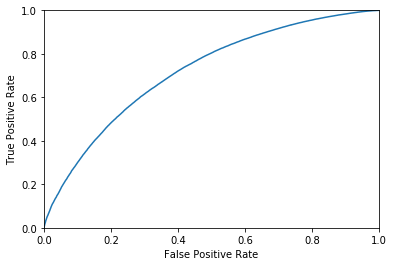

In [30]:
# Plot ROC Curve
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr)

In [31]:
auc_score=roc_auc_score(validationLabels,prediction)
print('AUC:',auc_score)

AUC: 0.718503797515442


###Are there any patterns discovered by the network?
####Lets examine if there are patterns by comparing the true/false integration datasets. We can do this by comparing the datasets of correctly predicted true/false predictions. We will do this by comparing the relative differences in frequencies of nucleotides in the datasets.
####We will install biopython to help us compare the datasets and sequences

In [32]:
#Lets determine a consensus sequence for correct our correct predictions
#For this we need to install biopython
!pip install biopython
import Bio
print(Bio.__version__)

     |████████████████████████████████| 2.3MB 2.7MB/s 
1.76


####Parse the DNA strings from which our one-hot encoded validation data was generated

In [0]:
#Lets parse the DNA strings for our validation data
dnaValidation=pd.read_csv('data/DNAString_validation.txt', sep=',',header=None)

####Add all correct predictions of true HIV integration events into a single dataset of DNA sequences
#####We will ignore the sequences that contain random nucleotides 'N' as these correspond to any random nucleotide and cannot be used in biopython for sequence analysis

In [0]:
# Add the DNA Sequences of correctly predicted true integration events into a list
#Following http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc214
from Bio.Seq import Seq
dnaSequences = []
for predIndex in range(prediction.size):
  if (prediction[predIndex] >= 0.5 and validationLabels[predIndex].numpy()[0] == 1):
    dnaString = dnaValidation[0][predIndex].upper()
    #Ignore predictions performed on sequences containing random nucleotides as biopython does not handle these ->
    if ("N" in dnaString): continue 
    dnaSequences.append(Seq(dnaString))
  

####Lets examine the proportion true integration events taken into consideration



In [35]:
#Lets calculate the percentage of correct predictions of true integrations not containing random nucleotides 
#We divide validationLabels/2 since the validation set contains equal proportions of true/false events
len(dnaSequences)/(validationLabels.shape[0].value/2)

0.8361411298047126

####Lets create an motif from the dataset for sequence analysis

In [0]:
#create a motif based on these sequences
from Bio import motifs
motifCorrectPredictions = motifs.create(dnaSequences)

####Lets examine the consensus sequence of these correctly predicted true integrations

In [37]:
#Get the consenus sequence for the correct predictions
print(motifCorrectPredictions.consensus)

ATTTTTATTTATAAATATATTTTTATATTAATAAATTTATTATTTTTTTAATTTATTTTTTTAAATTTTATAAATTTATTTAAAAAAATATTTTTTTTGGTTACCAAAAAAAATATTTTTTTAAATAAATTTATAAAATTTAATTAAATAAATTAATAAAATAATTAATTATTAATTTTTAATAATTTTATTATAATAAA


####When examining the above consenus sequence, wee see that there is a high rate of (A)denine and (T)hymine throughout the length of consensus sequence except in the middle. This is the position of HIV integration site. The HIV integration site contains a relative high frequency of (G)uanine and (C)ytosine compared to other positions in the DNA, the high occurrences of (G)uanine occurs right before the HIV integration position (at 100 bp) wheras (C)ytosine occurs a few bp after the integration site.
####Below we print out the index position where the high frequency of (G)uanine and (C)ytosine occurs, we have also marked the nucleotides at these positions in red.

In [40]:
#Lets format the high occurrence of (G)uanine in red and its position
print('The position of first guanine nucleotide is at position:', str(motifCorrectPredictions.consensus).index("G"))
print('The position of first cytosine nucleotide is at position:', str(motifCorrectPredictions.consensus).index("C"))
print(str(motifCorrectPredictions.consensus).replace("GG","\033[1;31mGG\x1b[0m").replace("CC","\033[1;31mCC\x1b[0m"))

The position of first guanine nucleotide is at position: 98
The position of first cytosine nucleotide is at position: 103
ATTTTTATTTATAAATATATTTTTATATTAATAAATTTATTATTTTTTTAATTTATTTTTTTAAATTTTATAAATTTATTTAAAAAAATATTTTTTTTGGTTACCAAAAAAAATATTTTTTTAAATAAATTTATAAAATTTAATTAAATAAATTAATAAAATAATTAATTATTAATTTTTAATAATTTTATTATAATAAA


####Lets compare the above consensus sequence with correctly predicted false integration sites (sites with randomly sampled DNA from the GRCh37/hg19 genome)

In [0]:
# Lets now predict the consensus sequence for correctly predicted false integration events
# Add the DNA Sequences of correctly predicted false integration events into a list
dnaFalseSequences = []
for predIndex in range(prediction.size):
  if (prediction[predIndex] < 0.5 and validationLabels[predIndex].numpy()[0] == 0):
    dnaString = dnaValidation[0][predIndex].upper()
    if ("N" in dnaString): continue 
    dnaFalseSequences.append(Seq(dnaString))

####Lets examine the proportion of false integration events we have taken into consideration for this analysis

In [42]:
#Lets calculate the proportion of correctly predicted false integration events that do not contain random nucelotides
len(dnaFalseSequences)/(validationLabels.shape[0].value/2)

0.3639580351810324

####Lets generate a similar consensus sequence for false integration events

In [43]:
#Get the consenus sequence for the correct predictions of false integrations
motifFalseCorrectPredictions = motifs.create(dnaFalseSequences)
print(motifFalseCorrectPredictions.consensus)

AATTTAATATATAAAAAAAAAAAAAAAAAATTTATAAAAAAAATAATAAAAAAAAAAAAAAAAAAATAAAAAAAAAAAAATTTTTTTTTAAAAAAAAAAAATTTTTTTTTTTTTTAAAAAAATAATTTTTTTTTTTTAAAATTATTTATATTTTTATAAAAATTTTTTAAAATTATTAAATATTAAAAATTTTAATATAT


####Above we see that there are no similar inconsistencies regarding the sudden large relative occurance of (G)uanine in the correctly predicted false integration data.
####Lets examine if there are more differences between these two sets by looking at the relative frequencies of the different nucleotides. We will compare these relative frequencies of nucleotides by substracing the total counts of nucleotides of correctly predicted false integration events from the dataset of correctly predicted true integration events .

In [44]:
'''
Lets compare differences in occurrences of nucleotides in correctly predicted true 
integrations events compared to correctly predicted false integration events to see
if there is a pattern in the relative frequencies of nucleotides at different positions
'''
from IPython.display import HTML, display
import tabulate
from operator import sub
diffA = ["Diff. A"]
diffA.extend(map(sub, motifCorrectPredictions.counts[0], motifFalseCorrectPredictions.counts[0]))
diffC = ["Diff. C"]
diffC.extend(map(sub, motifCorrectPredictions.counts[1], motifFalseCorrectPredictions.counts[1]))
diffG = ["Diff. G"]
diffG.extend(map(sub, motifCorrectPredictions.counts[2], motifFalseCorrectPredictions.counts[2]))
diffT = ["Diff. T"]
diffT.extend(map(sub, motifCorrectPredictions.counts[3], motifFalseCorrectPredictions.counts[3]))

table = [diffA,diffC,diffG, diffT]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Diff. A,14196,13719,13520,13161,13260,13458,13714,13998,13793,14494,14225,14151,13896,13518,14091,13626,14656,14539,14602,13901,13538,13557,13696,13498,14242,13497,13877,13725,14328,15265,14596,13935,13767,14482,14018,13506,13636,13999,14645,14174,13846,14255,13394,13207,13781,13045,13796,12796,13458,15130,15253,13499,13269,14261,14057,13702,14077,12858,13771,13532,12448,13741,14449,14950,13608,13235,13144,14049,13321,14619,13213,13570,14688,15019,11871,11611,11915,14068,14281,14592,11459,15904,13743,13323,15207,14944,17044,15655,13080,17010,10711,9735,11196,9067,10622,5950,2393,9982,9476,6439,8966,13872,22867,-1350,8018,17090,25847,16329,14878,13946,14127,14465,17041,14594,16149,13052,10265,10617,12340,12437,13161,11720,17887,15262,14422,14193,14604,15117,15381,15385,14000,13578,15013,13753,15751,14669,15255,15270,13301,12536,13714,14348,15182,13678,13749,14491,16010,15106,12698,14446,14555,15051,14396,14052,14262,15163,14002,14664,14147,14592,15171,13901,14475,14828,13821,14433,14528,14431,13695,13777,13715,13670,14263,15161,14888,13851,13638,13649,13246,13769,15119,14699,14000,14276,14598,14364,13969,13560,13188,13485,13654,13757,14313,13982,14652,14411,13167,13309,13087,13657
Diff. C,6930,7065,7550,7755,8341,7961,7297,6819,6762,6877,7341,7171,7462,7723,6681,6754,6140,6269,6563,6830,6541,6478,6085,7139,6929,6893,7104,7801,6268,5525,5656,6287,7220,6406,6417,6704,6796,6594,6274,5957,6317,6018,6934,6458,6435,6896,6672,7216,6872,5891,5220,6418,6872,5067,5613,6369,6018,6238,6577,6589,7547,7046,6993,5997,6763,6759,7463,7004,6123,6927,7260,7065,5822,4709,6891,7946,9225,6973,5272,6266,6152,6536,6677,8772,5683,7439,6746,5187,5740,4882,7139,8952,4833,6177,5610,9616,2843,855,4051,11227,5374,7236,4996,25917,20677,14540,10740,10267,11024,12645,11514,8871,6994,5451,7005,8073,7588,9142,8792,7560,8291,7740,6347,5909,7707,6421,5712,7169,7774,6403,7253,7519,6044,6554,6753,6283,6390,6955,7862,8187,6351,7044,6681,7715,7531,7988,5775,6503,8686,7536,6927,6367,6528,6682,7024,6729,7302,6798,7530,7176,6025,7380,6984,6681,6968,6292,6520,7018,7548,6906,7150,7539,7292,6005,5812,6212,6963,6977,7119,6872,6425,6517,6875,6537,5748,5996,6776,7424,7130,7296,7296,7115,6535,6766,6746,6882,7148,7400,7436,7158
Diff. G,6503,6936,7100,7411,6944,6807,7116,6540,6458,6247,6176,6477,6854,6873,6995,7334,6556,6020,6054,6530,7316,6646,6586,6778,6988,7231,7043,6127,5845,5849,7476,7497,7411,6808,7621,7189,6532,6595,7025,6630,7192,7322,6145,7287,7552,7130,7326,6722,7180,6675,6731,6781,6849,7733,9304,6519,5662,8167,7315,7776,6771,6704,6574,8066,7926,6478,6115,6036,6737,6279,5904,7687,6940,6751,7595,7083,5812,6399,7636,5895,6493,7631,8392,7427,8756,9175,7462,7890,7032,5028,6884,8665,11627,12735,11109,10256,10713,14169,20760,25721,4938,6828,5088,10714,3953,529,2699,9342,5235,5925,4723,8738,6773,4508,5506,5084,6822,7063,5740,8957,6317,6606,6798,6299,5671,7073,9597,7794,6825,4912,5989,7317,7282,6890,5964,7044,6992,6308,6844,6233,6951,7050,7596,6625,6876,6289,6109,6288,5955,5448,7088,6831,5609,6074,7153,6927,6601,7142,6336,6933,6998,6037,6204,5718,6274,6818,7028,6806,6743,6769,7436,6798,5816,5944,6845,8045,7434,7169,7264,7210,6515,6775,6966,7137,7012,6742,6738,7038,7211,7697,7222,7292,7197,6855,6624,6832,7410,8005,8289,7948
Diff. T,14273,14182,13732,13575,13357,13676,13775,14545,14889,14284,14160,14103,13690,13788,14135,14188,14550,15074,14683,14641,14507,15221,15535,14487,13743,14281,13878,14249,15461,15263,14174,14183,13504,14206,13846,14503,14938,14714,13958,15141,14547,14307,15429,14950,14134,14831,14108,15168,14392,14206,14698,15204,14912,14841,12928,15312,16145,14639,14239,14005,15136,14411,13886,12889,13605,15430,15180,14813,15721,14077,15525,13580,14452,15423,15545,15262,14950,14462,14713,15149,17798,11831,13090,12380,12256,10344,10650,13170,16050,14982,17168,14550,14246,13923,14561,16080,25953,16896,7615,-1485,22624,13966,8951,6621,9254,9743,2616,5964,10765,9386,11538,9828,11094,17349,13242,15693,17227,15080,15030,12948,14133,15836,10870,14432,14102,14215,11989,11822,11

####Above see that an interesting pattern ensues, even though the number false integration events taken into consideration are significantly less compared to the number of true integration events, we that some nucleotides occur significantly less in the DNA of true integration events at close proximity to the HIV integration site.
####We can make illustrate this more clearly by setting all positive differences to zero while retaining all the negative differences

In [45]:
'''
Lets eliminate positive differences and leave the negative differences as is
revealing a pattern at the site of HIV integration (in the middle of the sequence)
'''
diffANew = list(map(lambda x: 0 if type(x) == int and x > 0  else x,diffA))
diffCNew = list(map(lambda x: 0 if type(x) == int and x > 0  else x,diffC))
diffGNew = list(map(lambda x: 0 if type(x) == int and x > 0  else x, diffG))
diffTNew = list(map(lambda x: 0 if type(x) == int and x > 0  else x, diffT))
tableNew = [diffANew,diffCNew,diffGNew, diffTNew]
display(HTML(tabulate.tabulate(tableNew, tablefmt='html')))

Diff. A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Diff. C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Diff. G,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Diff. T,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1485,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


####Lets plot the above differences using a dot-plot to more easily examine the differences and highlight the relative differences in nucleotide frequencies around the HIV integration sites (at 100bp position)

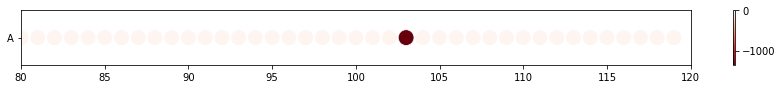

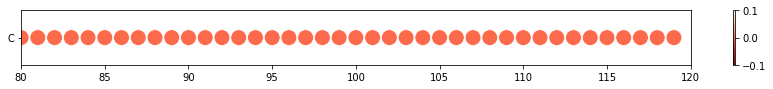

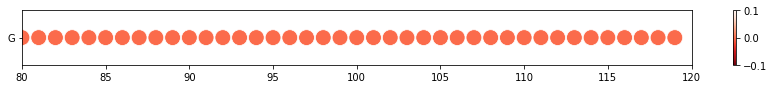

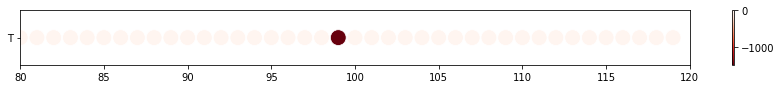

In [48]:
# Dot plot created using scatter plot (with help from https://github.com/Pjarzabek/DotPlotPython)
import seaborn as sns
from __future__ import division
seqLimitStart = 80
seqLimitEnd = 120
xLimit = np.arange(seqLimitStart,seqLimitEnd)

Thue = []
Ghue = []
Chue = []
Ahue = []
TyValues = ['T'] * (seqLimitEnd-seqLimitStart)
GyValues = ['G'] * (seqLimitEnd-seqLimitStart)
CyValues = ['C'] * (seqLimitEnd-seqLimitStart)
AyValues = ['A'] * (seqLimitEnd-seqLimitStart)
for position in np.arange(seqLimitStart+1,seqLimitEnd+1):
  Thue.append(diffTNew[position])
  Ghue.append(diffGNew[position])
  Chue.append(diffCNew[position])
  Ahue.append(diffANew[position])
  
def addSubplot(plt, yValues, hueValues):
 plt.subplots( figsize=(15,1))
 ax = sns.scatterplot(xLimit, yValues, hue=hueValues, s=250, legend=False, palette="Reds_r")
 scale_legend = plt.Normalize(min(hueValues), max(hueValues))  # Create the scale for the colormap.
 color_map = plt.cm.ScalarMappable(cmap="Reds_r", norm=scale_legend)  # Set the colormap
 ax.figure.colorbar(color_map)  # Add colormap legend
 plt.xlim([seqLimitStart,seqLimitEnd])  
 plt.plot()

addSubplot(plt, AyValues,Ahue)
addSubplot(plt, CyValues,Chue)
addSubplot(plt, GyValues,Ghue)
addSubplot(plt, TyValues,Thue)
plt.show()

###**Conclusion**
####Previously we showed a high relative frequency of guanine around the HIV integration site based on the consensus sequence calculated from DNA of correctly predicted true integration sites. Also, judging from the dot-plot above, which compares the relative distribution of DNA nucleotides from correctly predicted true integration sites with nucleotides from correctly predicted randomly sampled (false) integration sites, we clearly see that there is a significant difference in the relative distribution of nucleotides at the proviral HIV integration site. The difference is largest around the integration site itself (at 100 bp position).